# Week 8 Practical - Question 1 Template
## Abnormal Travellers

Using the data set 'tripadvisor_review.csv', cluster the data using k-means and a GMM and detect abnormal travelers. You can detect abnormalities by analysing how well a point fits the model. In the case of K-means, this means how far it is from the cluster centre relative to other points in the cluster, and for a GMM this means the negative log likelihood of the sample. You should split the data into a training and testing set (use the first $700$ samples for training) and detect travellers with abnormal opinions in the remaining $280$ samples. In completing this question you should consider the following:
1.  Determine the best value of $k$ for both K-means and the GMM.
2.  Visualise the learned clusters or cluster centres, and explore how the cluster distribution changes as you change the random seed.
3. Are the abnormal travellers detected the same for both methods? Are these travellers consistent across different random seeds?

Using the data set 'tripadvisor_review.csv', cluster the data using k-means and a GMM and detect abnormal
This data is composed of reviews on destinations in 10 categories mentioned across East Asia. Each traveler rating is mapped as Excellent(4), Very Good(3), Average(2), Poor(1), and Terrible(0) and average rating is used.

### Relevant Examples

The fourth clustering example, ``CAB420_Clustering_Example_4_Clustering_Applications.ipynb`` covers the selection of $K$ and detection of abnormal samples. ``CAB420_Clustering_Example_3_How_Many_Clusters.ipynb`` also looks at selecting $K$ and thus could also be of use.

### Suggested Packages

Mostly sklearn today. If you wanted though, [PyClustering](https://pyclustering.github.io/docs/0.8.2/html/index.html) is another package that offers a heap of clustering options.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

import pandas
import numpy
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial import distance
from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import dendrogram

import matplotlib.pyplot as plt
from matplotlib import cm

from datetime import datetime

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Step 1: Read the data and setup

This data is traveller ratings for 10 categories of activity, so we can (hopefully) see different types of travellers. The 10 activities are:
* Average user feedback on art galleries 
* Average user feedback on dance clubs 
* Average user feedback on juice bars 
* Average user feedback on restaurants 
* Average user feedback on museums 
* Average user feedback on resorts 
* Average user feedback on parks/picnic spots 
* Average user feedback on beaches 
* Average user feedback on theaters 
* Average user feedback on religious institutions

From the data, we can see that we have 980 users. The first column is a useless user ID, the rest are our category ratings.

In [14]:
data = pandas.read_csv('/content/drive/My Drive/Colab Notebooks/Data/tripadvisor/tripadvisor_review.csv');
print(data)

      User ID  Category 1  Category 2  Category 3  Category 4  Category 5  \
0      User 1        0.93        1.80        2.29        0.62        0.80   
1      User 2        1.02        2.20        2.66        0.64        1.42   
2      User 3        1.22        0.80        0.54        0.53        0.24   
3      User 4        0.45        1.80        0.29        0.57        0.46   
4      User 5        0.51        1.20        1.18        0.57        1.54   
..        ...         ...         ...         ...         ...         ...   
975  User 976        0.74        1.12        0.30        0.53        0.88   
976  User 977        1.25        0.92        1.12        0.38        0.78   
977  User 978        0.61        1.32        0.67        0.43        1.30   
978  User 979        0.93        0.20        0.13        0.43        0.30   
979  User 980        0.93        0.56        1.13        0.51        1.34   

     Category 6  Category 7  Category 8  Category 9  Category 10  
0       

We'll keep our data split very simple. The first 700 travellers form the training set, the rest go into testing. As noted above, we'll drop the first column as it contains nothing useful.

In [15]:
data_as_numpy = data.iloc[:, 1:].to_numpy()
from sklearn.model_selection import train_test_split 

train, test = train_test_split(data_as_numpy, test_size=0.25, random_state=4)
print(numpy.shape(train))
print(numpy.shape(test))

(735, 10)
(245, 10)


As a quick sanity check, we'll visualise the data with a box plot to see where the variation lies.

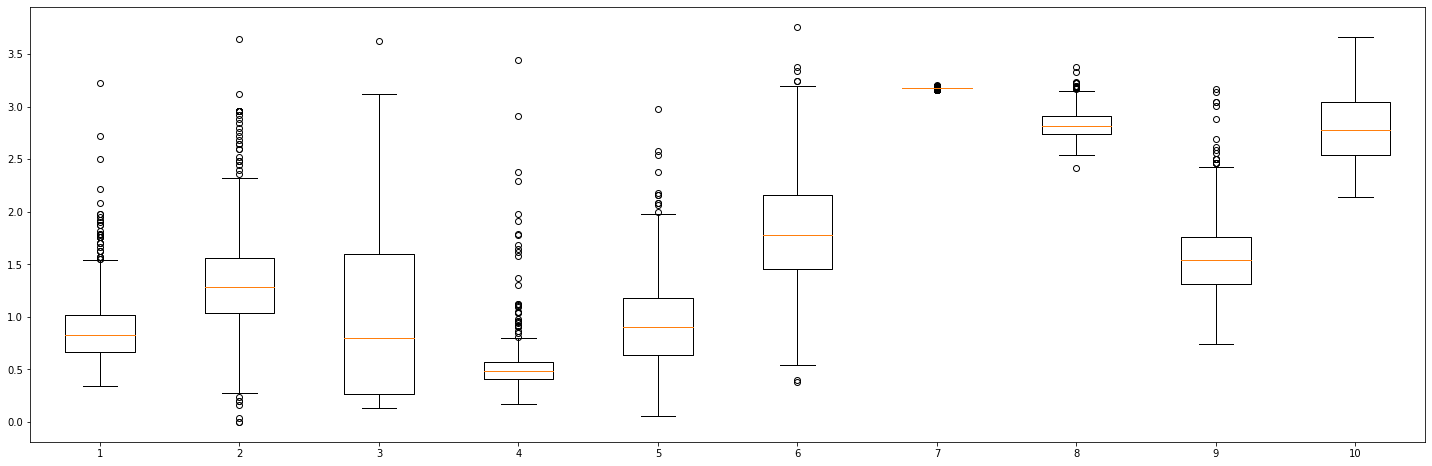

In [16]:
fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(train);

We see much more variation in some categories than others. 7 (parks), 8 (beaches) and 10 (religious institutions) are all consistently popular - so we won't expect to see cluster centres build around these.

However other types of thing are a lot more polarising, so we should see movement in these for our cluster centres.

### Step 2: Find the best K

First up, we need to determine K. In lecture examples we've look at:
* For K-means, taking the elbow of the reconstruction accuracy curve
* For K-means, taking the minimum of the approximate BIC curve
* For a GMM, taking the minimum of the BIC curve

There are a heap of other options too (for example, [silhouette analysis](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)).

In this step you should at least:
* Consider what model you wish to use to detect abnormalities
* Select a value of K for that model using a method of your choice. In doing this:
  * Don't feel you need to run every possible value of K. Feel free to look at values of say 2, 4, 6, ...; or even 5, 10, 15 ...
  * Remember that when you look at any of the plots listed above, your plots will be impacted by random variation in the clustering. This means that your plot may look a bit choppy. If you wish, you can run each clustering step a few times (with different random seeds) and average the resulting metric (reconstruction accuracy, BIC, approximate BIC, etc). However this will obviously make things slower.

I will note that it is worth looking at values of K for both K-means and a GMM to get a sense of how these can vary.

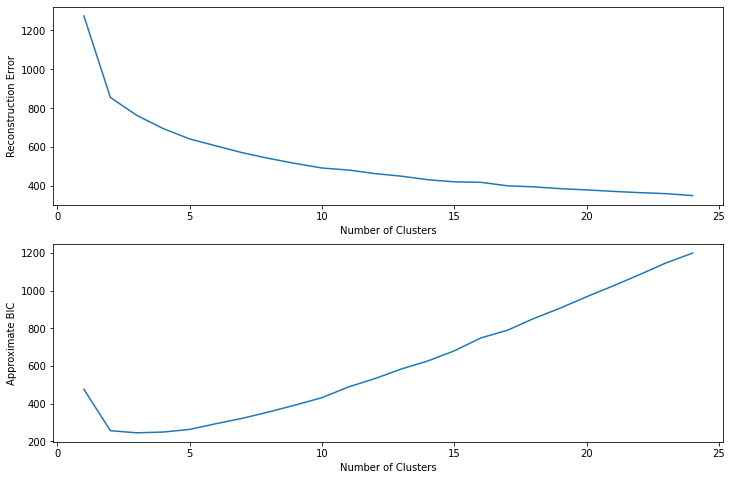

In [12]:
def compute_approximate_bic(kmeans, X):
    
    k = numpy.shape(kmeans.cluster_centers_)[0]*(numpy.shape(kmeans.cluster_centers_)[1] + 1)
    m = len(X)
    
    approx_bic = m*numpy.log(kmeans.inertia_ / m) + k*numpy.log(m)
    return approx_bic    

recon_error = []
bic = []
for i in range (1, 25, 1):
    kmeans = KMeans(n_clusters=(i), random_state=4).fit(train)
    bic.append(compute_approximate_bic(kmeans, train))
    recon_error.append(kmeans.inertia_)

fig = plt.figure(figsize=[12, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(range (1, 25, 1), recon_error)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Reconstruction Error');    
ax = fig.add_subplot(2, 1, 2)
ax.plot(range (1, 25, 1), bic)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Approximate BIC');    

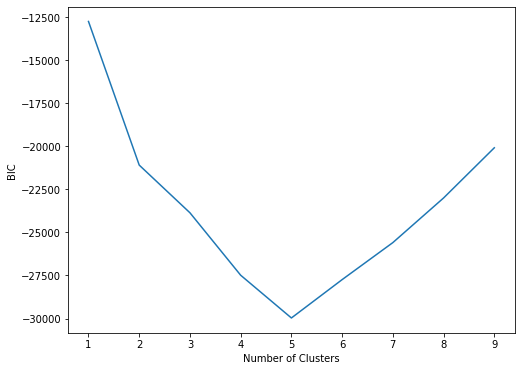

In [22]:
bics = []
for i in range (1, 10, 1):
  total_bic = 0
  for j in range(10):
    gmm = GaussianMixture(i, random_state=j)
    gmm.fit(train)
    total_bic = total_bic + gmm.bic(train)
  bics.append(total_bic)
    
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(1, 10, 1), bics)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('BIC');

### Step 3: Train a Model and Visualise it

The model training is hopefully fairly straightforward: using the value of K you select above, train the model of your choice.

In terms of visualisation, we don't strictly need to visualise data here, but it's often a good thing to do and does at least provide a sanity check. There are a few things you could consider:
* Visualise the cluster centres. This could just be looking at a histogram of each of them (i.e. 10 bars, for the 10 average ratings that we're clustering over) to get a sense of how disjoint the clusters are. Ideally, you'd see clusters that all look a bit different.
* Look at how many people belong to each cluster, while you will not see totally evenly sized clusters, you will hopefully see that each cluster describes a particular group and not just one or two people.
* Use t-SNE (or PCA) to visualise the data in 2D, including the cluster centres. This will help/provide an alternative to looking at the number of people in each cluster as you'll be able to visualise that easily with a 2D plot. This will also help you get a sense of the shape of the data, and you can plot abnormal people (when you identify them) on the same plot.

49


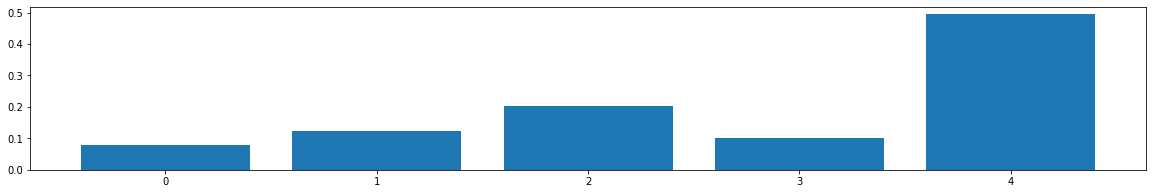

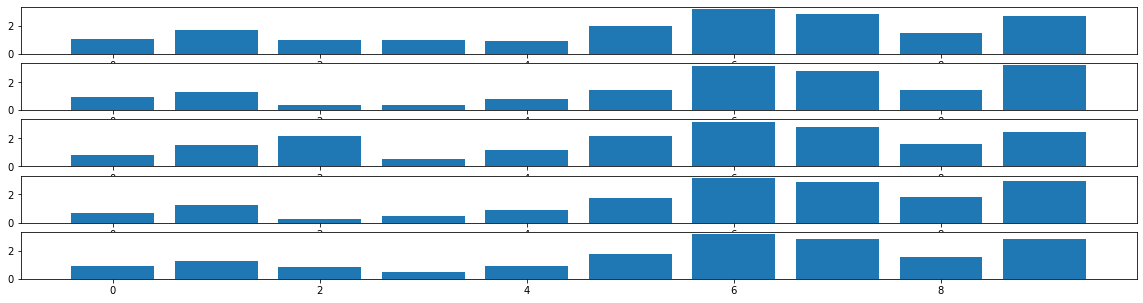

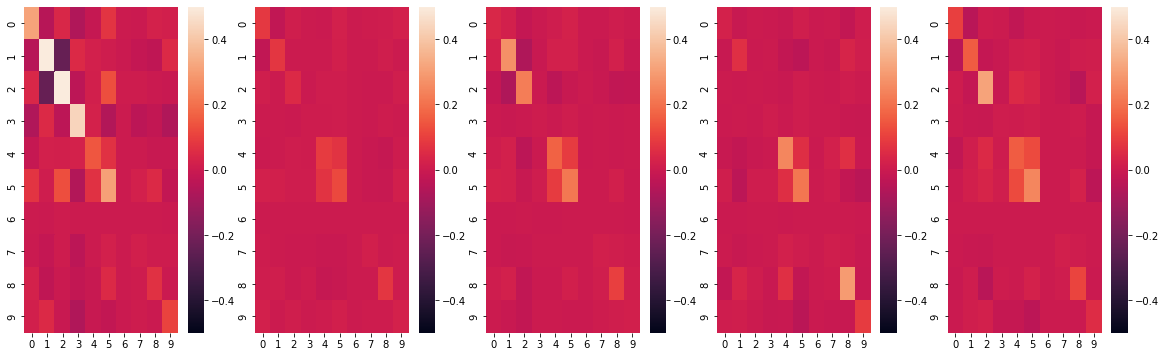

In [88]:
k = 5

#kmeans = KMeans(n_clusters=k, random_state=444).fit(train)
best_bic = 0
best_seed = 0
for i in range(50):
  gmm = GaussianMixture(k, random_state=i).fit(train)
  if (gmm.bic(train) < best_bic):
    best_bic = gmm.bic(train)
    best_seed = i

print(i)
gmm = GaussianMixture(k, random_state=best_seed).fit(train)

fig = plt.figure(figsize=[20, 3])
ax = fig.add_subplot(1, 1, 1)
ax.bar(range(k), gmm.weights_)


fig = plt.figure(figsize=[20, 5])
for i in range(k):
  ax = fig.add_subplot(k, 1, i+1)
  ax.bar(range(10), gmm.means_[i,:])

import seaborn
fig = plt.figure(figsize=[20, 6])
for i in range(k):
  ax = fig.add_subplot(1, k, i+1)
  seaborn.heatmap(gmm.covariances_[i], vmin=-0.5, vmax=0.5, ax=ax)  

[4.35365683e-01 1.74060656e-01 1.23682815e-01 7.08107564e-02
 6.82629192e-02 5.29932492e-02 4.04223265e-02 2.50514996e-02
 9.34177478e-03 8.31974271e-06]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0.5, 1.0, 'TSNE')

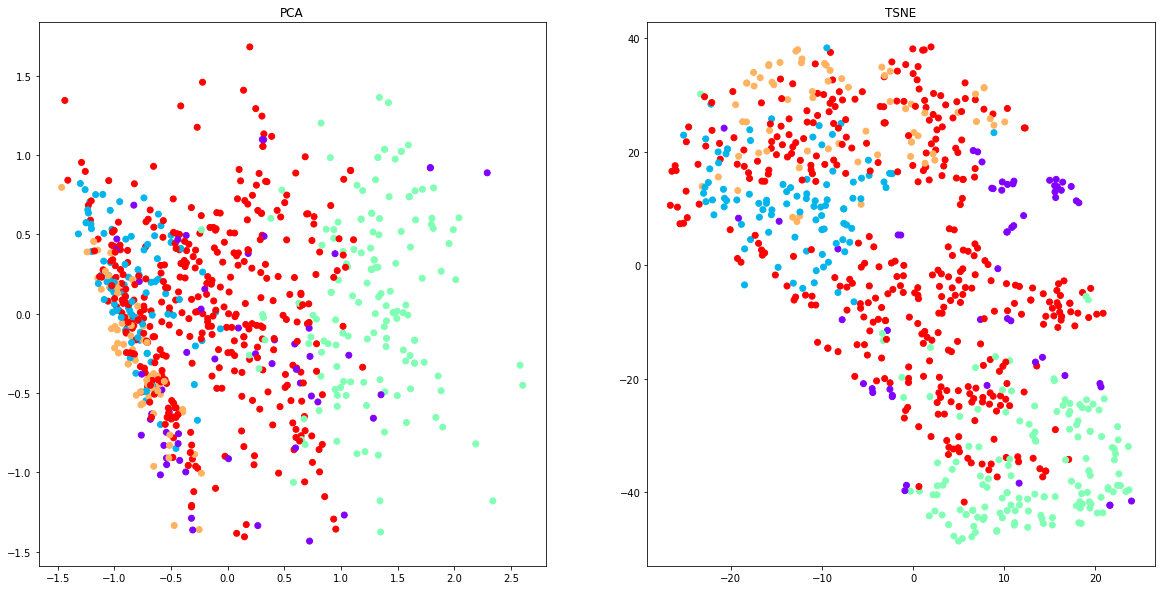

In [89]:
from sklearn import decomposition

#labels = kmeans.labels_
labels = gmm.predict(train)

pca = decomposition.PCA()
pca.fit(train)
print(pca.explained_variance_ratio_)
transformed = pca.transform(train)

embeddings = TSNE(random_state=4).fit_transform(train)

fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(1, 2, 1)
ax.scatter(transformed[:,0], transformed[:,1], c=labels, cmap=plt.get_cmap('rainbow'))
ax.set_title('PCA')

ax = fig.add_subplot(1, 2, 2)
ax.scatter(embeddings[:,0], embeddings[:,1], c=labels, cmap=plt.get_cmap('rainbow'))
ax.set_title('TSNE')

### Step 4: Finding Weird Travellers

The model that you use will determine how you do this step. If you are using K-means, there is no great way to deterime how likely a subject is. Distance to cluster centre, or something along those lines, is what we've used in lecture examples. For a GMM the likelihood (which you can obtain using the ``score_samples`` member function of the trained GMM object) gives a probability measure of how likley a sample (i.e. traveller) is given the GMM's learned distribution. This is an excellent way to approach abnormality detection.

Things to remember here are:
* The number of clusters, and your random seed, will impact what you find as abnormal. Run the clustering and anomaly detection a few times with different random seeds, number of clusters, etc, and observe how results change.
* If there are abnormal travellers in the training set, these may throw off results. The assumption when training a model for anomaly detection is that **the training set contains only normal instances**. This is almost certainly not the case here. You could attempt to santise the training set (i.e. remove abnormal samples), but that is a challenging and tedious task.

In [90]:
abnormal_amount = 0.05;
abnormal_count = int(len(test)*(1.0 - abnormal_amount))
abnormal_samples = len(test) - abnormal_count
print(abnormal_samples)

13


### K-Means (3 Clusters)

[130  56  53  88 224 163 117  20 123 126 213  54  83]

[ 50  56  53  88 224 163 117  20 123 126 213  54  83]

[130  56  53  88 224 163 117  20 123 126 213  54  83]

### K-Means (5 Clusters)

[157 130  53  88  20  56 117 163 123 126  54 213  83]

### GMM (5 Clusters)

[ 88 243  50  54  51  83 130  53 224  59 123 213 126]


In [92]:
labels = gmm.predict(test)
distances = gmm.score_samples(test)
sorted_distances = numpy.flip(numpy.argsort(distances))

print(sorted_distances[-abnormal_samples:])
print(distances[sorted_distances[-abnormal_samples:]])

#labels = kmeans.predict(test)
#distances_full = kmeans.transform(test)
#distances = numpy.min(distances_full, axis=1)

#sorted_distances = numpy.argsort(distances)
#print(sorted_distances[-abnormal_samples:])
#print(labels[sorted_distances[-abnormal_samples:]])
#print(distances_full[sorted_distances[-abnormal_samples:], :])
#print(distances[sorted_distances[-abnormal_samples:]])

[ 88 243  50  54  51  83 130  53 224  59 123 213 126]
[ -5.35623738  -5.42103267  -5.54866542  -6.00513577  -7.14231384
  -8.18757628  -8.62406356  -9.70045807 -10.90098901 -11.45620365
 -11.84719859 -15.52747638 -16.07875199]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


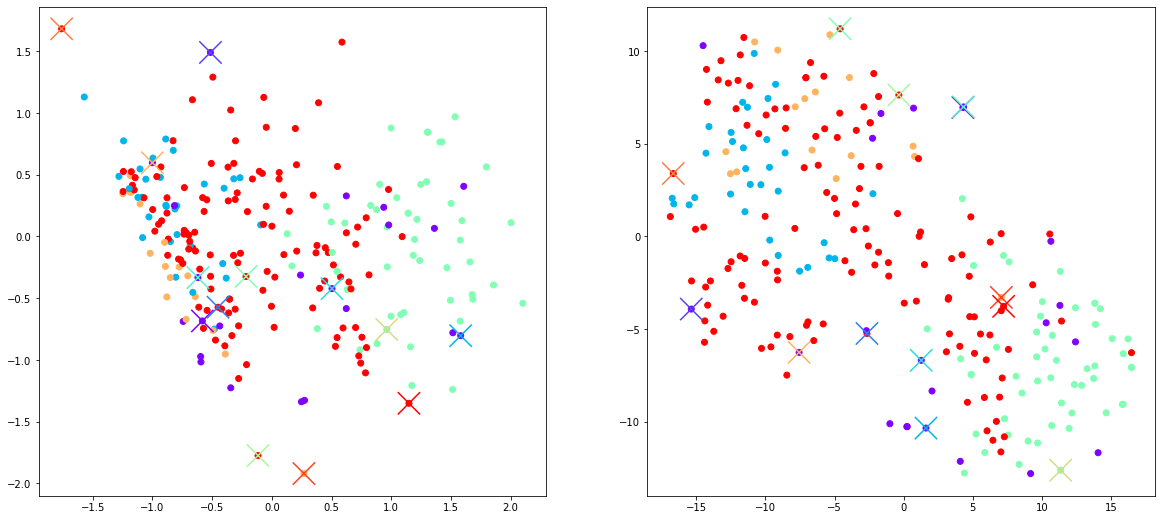

In [93]:
transformed = pca.transform(test)
embeddings = TSNE(random_state=4).fit_transform(test)

fig = plt.figure(figsize=[20, 9])
ax = fig.add_subplot(1, 2, 1)
scatter = ax.scatter(transformed[:,0], transformed[:,1], c=labels, cmap=cm.get_cmap('rainbow'));
ax.scatter(transformed[sorted_distances[abnormal_count:],0], transformed[sorted_distances[abnormal_count:],1], marker='x', s=500, c=range(abnormal_samples), cmap=cm.get_cmap('rainbow'))

ax = fig.add_subplot(1, 2, 2)
scatter = ax.scatter(embeddings[:,0], embeddings[:,1], c=labels, cmap=cm.get_cmap('rainbow'));
ax.scatter(embeddings[sorted_distances[abnormal_count:],0], embeddings[sorted_distances[abnormal_count:],1], marker='x', s=500, c=range(abnormal_samples), cmap=cm.get_cmap('rainbow'))

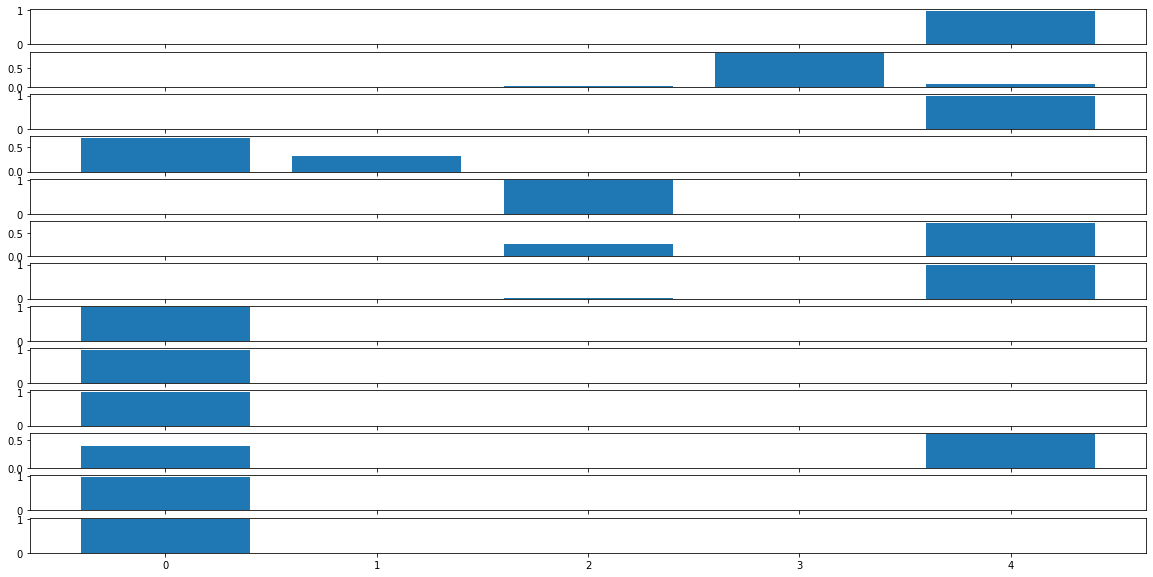

In [97]:
posteriors = gmm.predict_proba(test)

fig = plt.figure(figsize=[20, 10])
for i in range(abnormal_samples):
  ax = fig.add_subplot(abnormal_samples, 1, i+1)
  ax.bar(range(k), posteriors[sorted_distances[-(i+1)], :])

[1.33847042e-03 4.09120112e-26 9.66790039e-05 1.26704096e-10
 9.98564850e-01]
[1.93835013e-05 6.60732544e-30 3.82525977e-05 5.81484987e-01
 4.18457377e-01]


<BarContainer object of 10 artists>

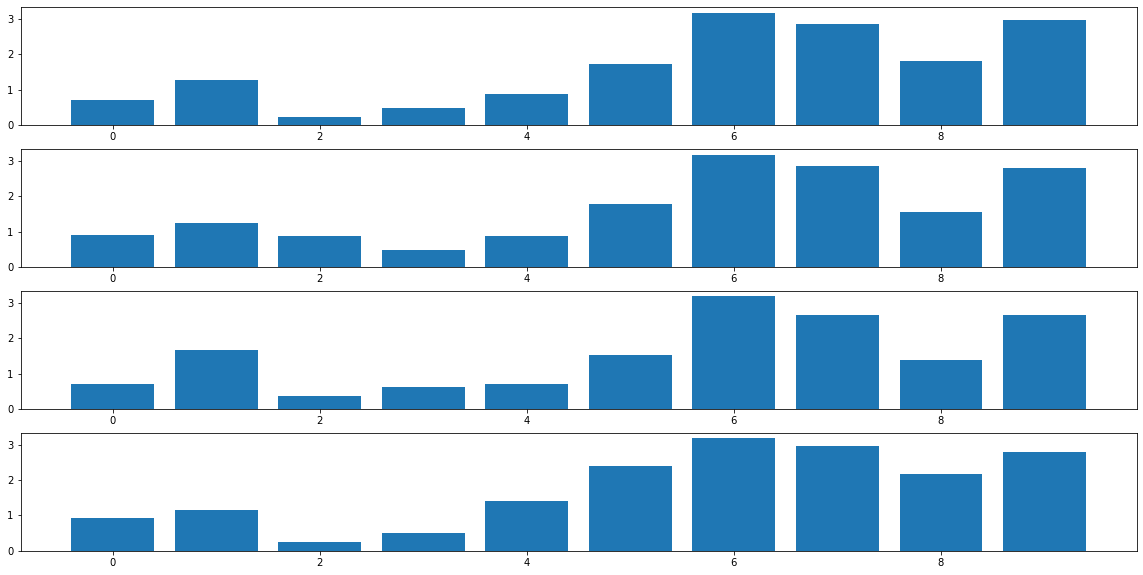

In [103]:
print(posteriors[0,:])
print(posteriors[12,:])

fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(4, 1, 1)
ax.bar(range(10), gmm.means_[3,:])
ax = fig.add_subplot(4, 1, 2)
ax.bar(range(10), gmm.means_[4,:])
ax = fig.add_subplot(4, 1, 3)
ax.bar(range(10), test[0, :])
ax = fig.add_subplot(4, 1, 4)
ax.bar(range(10), test[12, :])

